# Compute and compare prediction scores across different rankings (on a fine grained level)

### Imports

In [5]:

import numpy as np
import sys
import os
import util_scripts.stats_utils as su
import util_scripts.analysis_utils as au
import compare_rankings as cr
sys.path.append('..')
# Add the project root directory
sys.path.append(os.path.abspath("../rule_based"))  # or the absolute path to your project

from rule_based.rule_dataset import RuleDataset
from rule_based.eval import evaluate



## User Input

In [6]:
dataset_name = 'tkgl-icews14'
rankings_filename = 'tkgl-icews14-rankings_test_conf_0_corr_conf_0_noisyor_crules_frules_zrules_pvalue_30_num_top_rules_10_multi.txt'  # replace with name of your rankings file - 
# you can generate rankings using the counttrucola main.py. it will be stored in files/rankings/dataset_name/
# you can also use your own rankings file, as long as it is in the same format
# rankings format example:
# 25 13 ? 337
# 15 0.8158242432096148 44 0.5658675347599267 87 0.2962600387521216 ...

eval_mode ='test'
path_rankings_test = os.path.join('..', 'files', 'rankings', dataset_name, rankings_filename) # path to the rankings file.


# rankings_files_to_compare_to:
rankings_files_to_compare_to = {'regcn': 'ICEWS14_rankings_regcn.txt'} # can be empty


figs_dir = os.path.join('..', 'files', 'analysis', dataset_name)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)


## Figures and Stats

### 1. Compute some basic dataset stats

In [7]:
## read dataset and compute some stats
dataset =  RuleDataset(name=dataset_name)
stats_df, num_triples_dict, rel_df = su.compute_stats(dataset_name, dataset)
# stats_df

raw file found, skipping download
Dataset directory is  c:\Users\jgasting\PythonScripts\counttrucola\tgb/datasets\tkgl_icews14
loading processed file
num_rels:  230
>>> loading and indexing of dataset 2.919 seconds
>>> average number of time steps for a triple: 1.804
>>> checked order of time steps, everything is fine
tkgl-icews14 first timestamp: 2014-01-01 last timestamp: 2014-12-31
181460
>>> read 181460 triples from time 364 to 0
>>> read 14742 triples from time 364 to 334
DATATSET:  tkgl-icews14
all:       7371
previous:  776
sometime:  3860
f-direct (DRec):   0.10527743861077195
f-sometime (Rec): 0.5236738570071904
the mean number of timesteps that a triple appears in is 1.803956655731186
the median number of timesteps that a triple appears in is 1.0
the maximum number of timesteps that a triple appears in is 188
number of timesteps is 365
number of total triples is 90730
number of distinct triples is 50295
the mean max number of 100*consecutive timesteps/number of timesteps that

### 2. Evaluation Part 1: Compute the MRR, e.g. MRR per relation of CountTRuCoLa

In [8]:
## compute the mrr (per relation, per timestep from test set)
testmrr, testhits10, testhits1, testhits100, testmrrperrel, testhits1perrel, testmrrperts, testhits1perts =evaluate(dataset, path_rankings_test, progressbar_percentage=0.01, evaluation_mode=eval_mode, eval_type='random')

# extend the rel_df with the mrr per relation
num_rels = dataset.num_rels

for rel in rel_df['relation']:
    if int(rel) in testmrrperrel:
        rel_df.loc[rel_df['relation'] == rel, 'tail'] = testmrrperrel[rel][0]
        inverse_rel = dataset.inverse_rel_dict[rel]
        rel_df.loc[rel_df['relation'] == rel, 'head'] = testmrrperrel[inverse_rel][0]


loading negative test samples
>>> starting evaluation for every triple, in the  test set


16506it [00:03, 4906.30it/s]                           


eval mode: test
mean mrr: 0.4499810318099274
mean hits@1: 0.35978835978835977
mean hits@10: 0.6209469542802876
mean hits@100: 0.7878171211504544
time to evaluate: 17.53731632232666


### 2. Evaluation Part 2: Compute MRR of other methods, for comparison 

In [9]:
## compare rankings - write the values where one is better than the other
mrrperrel, hits1perrel, mrrperts, hits1perts = {}, {}, {}, {}
for method_to_compare, path_rankings_compare_filename in rankings_files_to_compare_to.items():
    # this might be slow if the method assigns scores to each node in the dataset.
    path_rankings_compare = os.path.join('..', 'files', 'rankings', dataset_name, path_rankings_compare_filename)
    mrr, hits10, hits1, hits100, mrrperrel_1, hits1perrel_1, mrrperts_1, hits1perts_1 =evaluate(dataset, path_rankings_compare, progressbar_percentage=0.01, evaluation_mode=eval_mode, eval_type='random')
    mrrperrel[method_to_compare], hits1perrel[method_to_compare], mrrperts[method_to_compare], hits1perts[method_to_compare] = mrrperrel_1, hits1perrel_1, mrrperts_1, hits1perts_1

# add the methods performance per rel to the relation dataframe
for method_to_compare in mrrperrel.keys():
    for rel in rel_df['relation']:
        if int(rel) in mrrperrel[method_to_compare]:
            rel_df.loc[rel_df['relation'] == rel, method_to_compare+'_tail'] = mrrperrel[method_to_compare][int(rel)][0]
            rel_df.loc[rel_df['relation'] == rel, method_to_compare+'_head'] = mrrperrel[method_to_compare][int(dataset.inverse_rel_dict[rel])][0]



loading negative test samples
>>> starting evaluation for every triple, in the  test set


16506it [00:13, 1246.47it/s]                           


eval mode: test
mean mrr: 0.4211267885735115
mean hits@1: 0.3135938135938136
mean hits@10: 0.6266449599782933
mean hits@100: 0.8488671822005155
time to evaluate: 344.03766083717346


### 3. Plot MRR per relation to compare the Methods

saved in  ..\files\analysis\tkgl-icews14\rel_mrrperrel_occ_tkgl-icews14_regcn.pdf


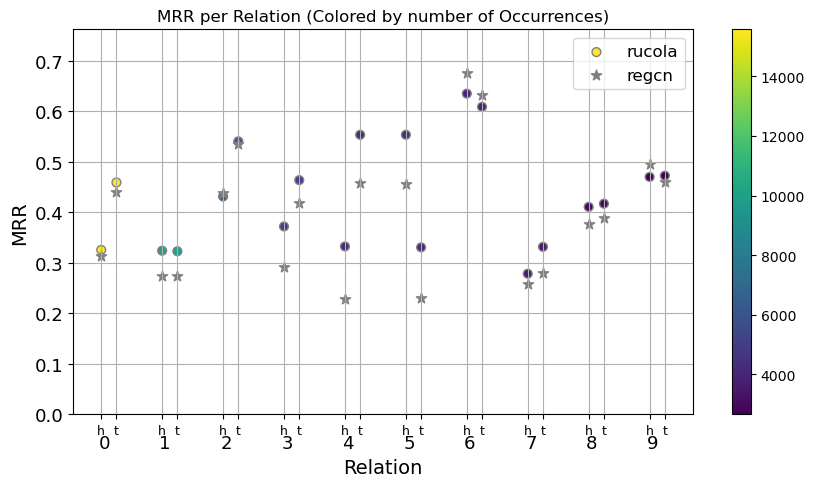

In [11]:
# plot the mrr per relation for the method and the methods to compare to
au.plot_mrr_per_relation(rel_df, figs_dir, dataset_name, num_rels_plot=10, head_tail_flag=True, mode='num_occurences', mrrperrel=mrrperrel)

# alternative:
# au.plot_mrr_per_relation(rel_df, figs_dir, dataset_name, num_rels_plot=10, head_tail_flag=True, mode='recurrency_degree', mrrperrel=mrrperrel)

### 4. Compare rankings between ranking files

Compare the rankings of different ranking files and write the quadruples where the rankings in rankings_filenameare significantly 
better than in rankings_files_to_compare_to to a file. 
You can compare the rankings either for all relations or only for a subset of relations (relations_of_interest).

The output file can be used as input (quadruples.txt) for the explainer and is automatically put into the directory explanations_path.
Further, create a file that contains the quadruples where the rankings in rankings_better_name are significantly better than in rankings_worse_name and the ranks
of both files for the quadruples to filebetter_path.

This can also be done the other way round, by switching rankings_worse_name and rankings_better_name

In [12]:
relations_of_interest = [1] #None # if None, all relations are considered
path = os.path.join('..', 'files', 'rankings', dataset_name)
rankings_better_name = rankings_filename
for method, rankings_worse_name in rankings_files_to_compare_to.items():
    experiment_name = method
    outpath = os.path.join('..', 'files', 'explanations', experiment_name, 'input')
    if not os.path.exists(outpath):
        os.makedirs(outpath)
    filebetter_path = os.path.join(outpath, "filesb_better_all_"+dataset_name+".txt")
    explanations_path = os.path.join(outpath, "quadruples.txt")  # this can be used as input for the explainer
    compare_df = cr.compare_rankings(rankings_worse_name, rankings_better_name, path, eval_mode, filebetter_path, explanations_path, dataset_name, relations_of_interest)

compare_df

raw file found, skipping download
Dataset directory is  c:\Users\jgasting\PythonScripts\counttrucola\tgb/datasets\tkgl_icews14
loading processed file
num_rels:  230
>>> loading and indexing of dataset 4.254 seconds
>>> average number of time steps for a triple: 1.804
>>> checked order of time steps, everything is fine
loading negative test samples
>>> starting evaluation for every triple, in the  test set


  5%|▍         | 735/14742 [00:00<00:11, 1261.72it/s]


in total we had 52 cases where the rankings in file better_rule performed [significantly] better than the rankings in file worse_rule and the better_rule had hits@1 of 1
the quadruples are written to ..\files\explanations\regcn\input\quadruples.txt and can be used as input for the explainer
the quadruples and the ranks in both files are written to ..\files\explanations\regcn\input\filesb_better_all_tkgl-icews14.txt


,src,rel,dst,t,rank_worse,rank_better
0,891,1,649,334,6,1
1,597,1,5295,336,134,1
2,5295,1,597,336,29,1
3,2452,1,1349,337,22,1
4,56,1,2866,337,51,1
5,2866,1,56,337,37,1
6,2866,1,5737,337,3,1
7,5737,1,2866,337,39,1
8,3064,1,147,337,4,1
9,950,1,2950,337,29,1
